Scratch Jupyter Noteboook

In [19]:
import numpy as np
from numpy.typing import NDArray
import matplotlib.pyplot as plt
from matplotlib import cm
import nonlinear_approximator as na
%matplotlib inline
from importlib import reload

def reload_modules():
    modules = [
        na,
        na.activations,
        na.model,
        na.inference,
        na.params,
        na.training
    ]
    for mod in modules:
        reload(mod)

# Parameters

In [20]:
num_samples_train = 1000
num_samples_test = 1000

# XOR Function

In [21]:
def xor(x: NDArray) -> int:
    if x[0] >= 0:
        # First or Fourth Quadrants
        if x[1] >= 0:
            # First Quadrant
            return 0
        # Fourth Quadrant
        else:
            return 1

    # Second or Third Quadrants
    else:
        # Second Quadrant
        if x[1] >= 0:
            return 1

        # Fourth Quadrant
        else:
            return 0

# Instantiate Model 

In [ ]:

config = na.params.RegressionParams(
    width=100,
    depth=50,
    input_dimension=2,
    transform_type=na.activations.TransformType.TENT,
    transform_params=na.params.TentParams(mu=1.99),
    output_dimension=1,
    storage_path='./xor'
)

model = na.model.NonlinearRegressorModel(config)

Storage path not configured, storing all model parameters in memory.


# Neuron Preferred Directions

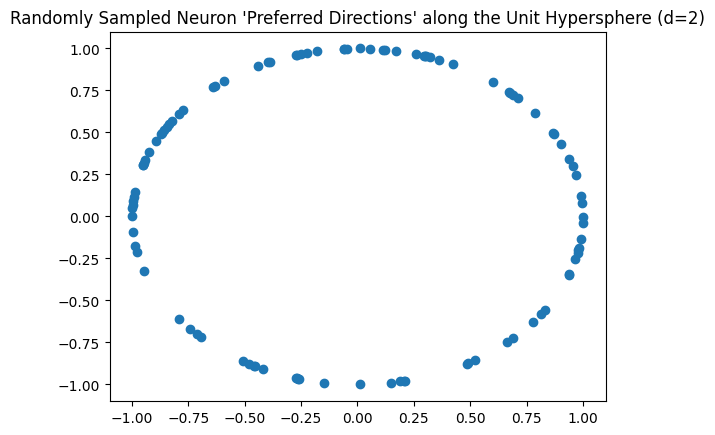

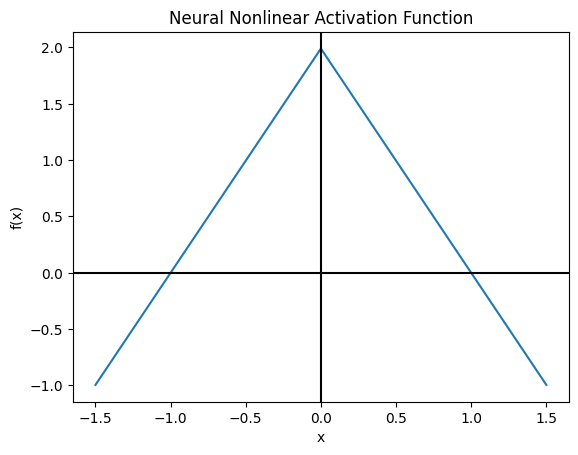

In [ ]:

neurons = model._neurons
plt.scatter(neurons[0, :], neurons[1, :])
plt.title(
    "Randomly Sampled Neuron 'Preferred Directions' along the Unit Hypersphere (d=2)"
)
plt.show()

plt.title("Neural Nonlinear Activation Function")
xs = np.asarray(np.linspace(-1.5, 1.5, num=1000))
# plt.plot(xs, gauss(xs, alpha=nonlinear_params['alpha'], beta=nonlinear_params['beta']))
plt.plot(xs, na.activations.tent(xs, params=config.transform_params))

# plt.xlim([-1, 1])
# plt.ylim(-1,1)
plt.xlabel("x")
plt.axhline(0, c="k")
plt.axvline(0, c="k")
plt.ylabel("f(x)")
plt.show()

# Topological Mixing

/tmp/ipykernel_23131/3430885561.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("inferno", config.depth + 1)
/tmp/ipykernel_23131/3430885561.py:10: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(


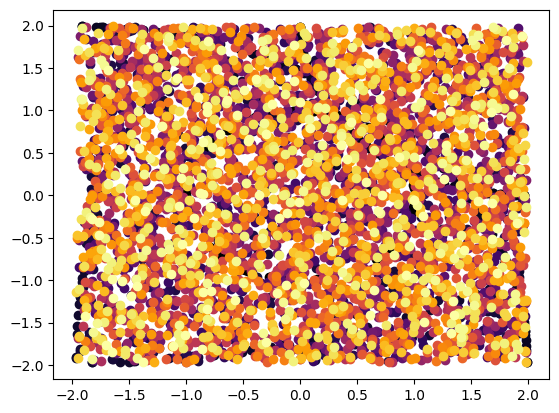

In [24]:
colors = cm.get_cmap("inferno", config.depth + 1)

reload_modules()
activations_identity = na.activations.compute_activations(
    neurons, np.asarray(np.eye(2)), config
)

plt.scatter(neurons[0, :], neurons[1, :], color="black")
for idx_layer in range(1, config.depth):
    plt.scatter(
        activations_identity[0, idx_layer, :],
        activations_identity[1, idx_layer, :],
        label=f"Pass {idx_layer + 1}",
        c=colors(idx_layer + 1),
    )

# plt.xlim([-1.25, 1.25])
# plt.ylim([-1.25, 1.25])
# plt.legend()
plt.show()

# Generate Samples Uniformly Distributed on Unit Disk, Train the Model

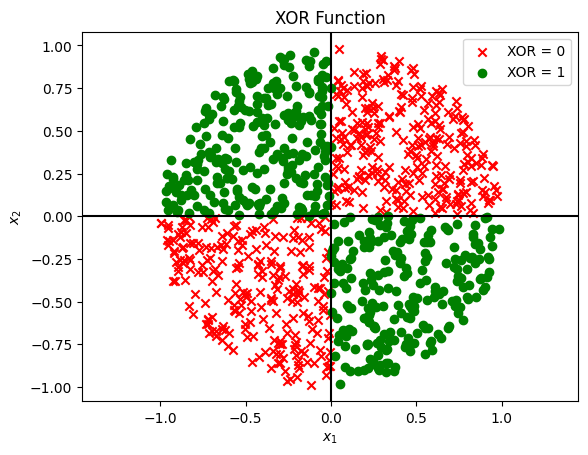

In [25]:

# Create  
test_samples = np.random.normal(
    loc=0, scale=1, size=(config.input_dimension, num_samples_test)
)
test_samples /= np.linalg.norm(test_samples, axis=0)
train_samples = np.random.normal(
    loc=0, scale=1, size=(config.input_dimension, num_samples_train)
)
train_samples /= np.linalg.norm(train_samples, axis=0)

# Scale by radii distributed according to d^th root (where d is dimension) to get uniform density
test_radii = np.random.uniform(0, 1, size=num_samples_test)
train_radii = np.random.uniform(0, 1, size=num_samples_train)
test_samples *= np.sqrt(test_radii)
train_samples *= np.sqrt(train_radii)

# Compute XOR, then use making to plot classification
xors_train = np.expand_dims(
    np.array([xor(train_samples[:, i]) for i in range(num_samples_train)]), axis=-1
)

mask_0 = (xors_train == 0).squeeze()
mask_1 = (xors_train == 1).squeeze()
plt.scatter(
    train_samples[0, mask_0],
    train_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    train_samples[0, mask_1],
    train_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title("XOR Function")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()
plt.show()

# Train an XOR Decoder

In [26]:
train_samples.shape, xors_train.shape

((2, 1000), (1000, 1))

In [27]:
reload_modules()
model = na.model.NonlinearRegressorModel(config)
model.fit(train_samples.T, xors_train)

Storage path not configured, storing all model parameters in memory.
Passing activations with shape: (1000, 50, 100)
Passing output with shape (1000, 1)


ACtS SHAPE: {acts.shape}, decoders shape: {decoders.shape}


100%|██████████| 100/100 [00:00<00:00, 713.78it/s]


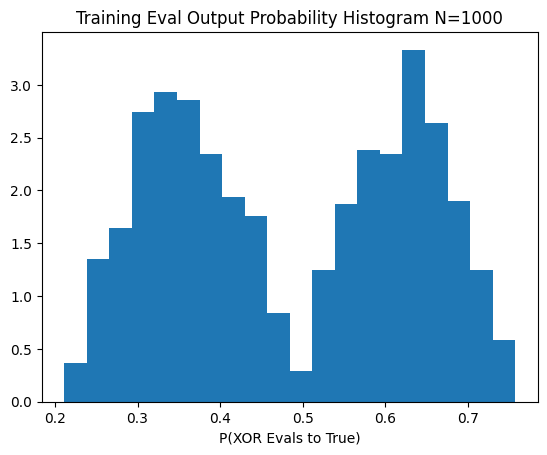

In [29]:
reload_modules()
from functools import partial
model.predict = partial(na.model.NonlinearRegressorModel.predict, model)
outputs = model.predict(train_samples.T)

#  (D x S) x (D x Y).T @ (D x S) ==> Y x
plt.hist(outputs.T, 20, density=True)
plt.title(f"Training Eval Output Probability Histogram N={len(xors_train)}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

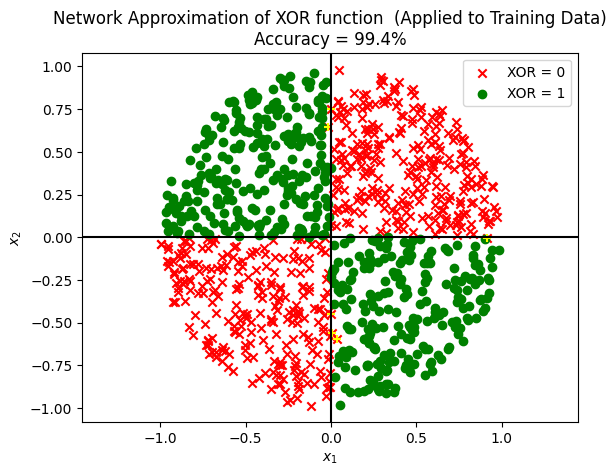

In [30]:
xor_thresh = 0.5

xors_train_rounded = outputs.copy().squeeze()
xors_train_rounded[xors_train_rounded <= xor_thresh] = 0
xors_train_rounded[xors_train_rounded > xor_thresh] = 1
xor_train_actual = np.array(
    [xor(train_samples[:, i]) for i in range(train_samples.shape[1])]
)


mask_0 = np.isclose(xors_train_rounded, 0).squeeze()
mask_1 = np.isclose(xors_train_rounded, 1).squeeze()
plt.scatter(
    train_samples[0, mask_0],
    train_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    train_samples[0, mask_1],
    train_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_train_rounded != xor_train_actual).squeeze()
plt.scatter(
    train_samples[0, mask_incorrect],
    train_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Training Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()


# Test XOR Approximation

ACtS SHAPE: {acts.shape}, decoders shape: {decoders.shape}


100%|██████████| 100/100 [00:00<00:00, 668.56it/s]


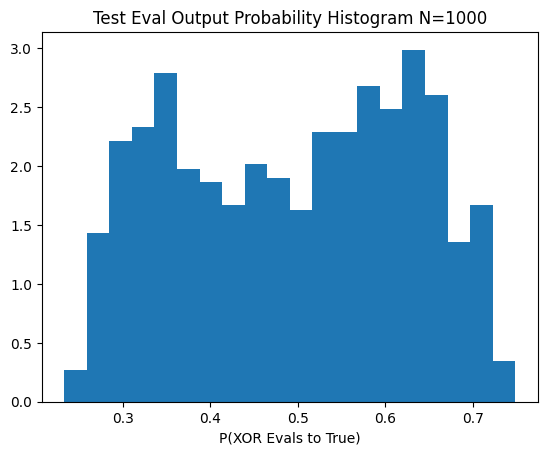

In [31]:
outputs_test = model.predict(test_samples.T) 
#  (D x S) x (D x Y).T @ (D x S) ==> Y x
plt.hist(outputs_test.T, 20, density=True)
plt.title(f"Test Eval Output Probability Histogram N={test_samples.shape[1]}")
plt.xlabel("P(XOR Evals to True)")
plt.show()

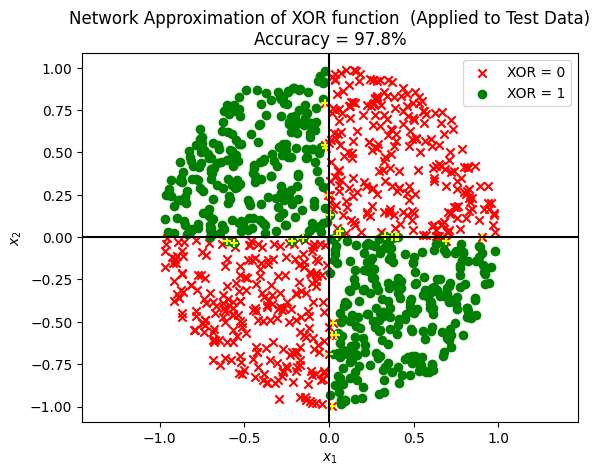

In [32]:
xor_thresh = 0.5

xors_test_rounded = outputs_test.copy().squeeze()
xors_test_rounded[xors_test_rounded <= xor_thresh] = 0
xors_test_rounded[xors_test_rounded > xor_thresh] = 1
xors_test_actual = np.array(
    [xor(test_samples[:, i]) for i in range(test_samples.shape[1])]
)


mask_0 = np.isclose(xors_test_rounded, 0).squeeze()
mask_1 = np.isclose(xors_test_rounded, 1).squeeze()
plt.scatter(
    test_samples[0, mask_0],
    test_samples[1, mask_0],
    c="red",
    marker="x",
    label="XOR = 0",
)
plt.scatter(
    test_samples[0, mask_1],
    test_samples[1, mask_1],
    c="green",
    marker="o",
    label="XOR = 1",
)

mask_incorrect = (xors_test_rounded != xors_test_actual).squeeze()
plt.scatter(
    test_samples[0, mask_incorrect],
    test_samples[1, mask_incorrect],
    marker="+",
    c="yellow",
)

plt.axis("equal")
plt.axvline(x=0, c="black")
plt.axhline(y=0, c="black")

plt.title(
    f"Network Approximation of XOR function  (Applied to Test Data)\nAccuracy = {100 * (1 - sum(mask_incorrect) / num_samples_train)}%"
)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.legend()